#Identifing Sign Language Digits using ConvNet

## *Importing the Packages*

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)


*We can display images in the dataset, images are 64x64 in RGB format*

## The Functional API
This Keras API can be used for non-sequential propogation. This can also be interpretted as the skip connection b/w layers. Like, output of one layer can go as an input after skipping some layers.In this, nodes are connected as a Graph(which is non linear).

### Load the Signs Dataset
The Signs dataset comprises of 6 signs, which are numbers from 0 to 5.

In [66]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes=load_signs_dataset()

Let's take some example of image from the dataset

In [67]:
Y_train_orig.shape

(1, 1080)

y= 4


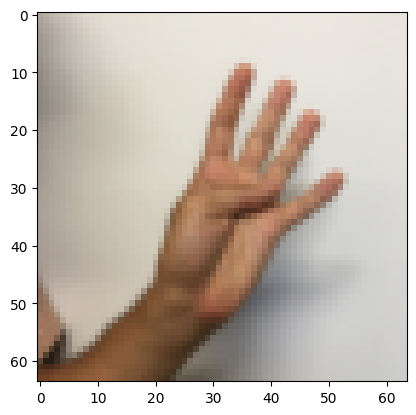

In [68]:
index=5
plt.imshow(X_train_orig[index])
print(f"y= {np.squeeze(Y_train_orig[:, index])}")
plt.show()

### Split into Train/Test Sets

In [70]:
X_train=X_train_orig/255.
X_test=X_test_orig/255.

Y_train=convert_to_one_hot(Y_train_orig, 6).T
Y_test=convert_to_one_hot(Y_test_orig, 6).T

print(f"No. of training examples in train set: {X_train.shape[0]}")
print(f"No. of test examples in test set: {X_test.shape[0]}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

No. of training examples in train set: 1080
No. of test examples in test set: 120
X_train shape: (1080, 64, 64, 3)
X_test shape: (120, 64, 64, 3)
Y_train shape: (1080, 6)
Y_test shape: (120, 6)


### Convolution Model

* Conv2D: Use 8 4 by 4 filters, stride 1, padding is "SAME"
* ReLU
* MaxPool2D: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
* Conv2D: Use 16 2 by 2 filters, stride 1, padding is "SAME"
* ReLU
* MaxPool2D: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
* Flatten the previous output.
* Fully-connected (Dense) layer: Apply a fully connected layer with 6 neurons and a softmax activation.

In [60]:
def convolutional_model(input_shape):
  input_img=tf.keras.Input(shape=input_shape)
  Z1 = tfl.Conv2D(8, 4, activation='linear', padding="same", strides=1)(input_img)
  A1 = tfl.ReLU()(Z1)
  P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
  Z2 = tfl.Conv2D(16, 2, activation='linear', padding="same", strides=1)(P1)
  A2 = tfl.ReLU()(Z2)
  P2 = tfl.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
  F = tfl.Flatten()(P2)
  outputs = tfl.Dense(6, activation='softmax')(F)
  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

In [61]:
conv_model=convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

conv_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310 (5.12 KB)

 Trainable params: 1,310 (5.12 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [71]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.1614 - loss: 1.7964 - val_accuracy: 0.1750 - val_loss: 1.7830
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.1612 - loss: 1.7854 - val_accuracy: 0.1250 - val_loss: 1.7782
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.1965 - loss: 1.7814 - val_accuracy: 0.1583 - val_loss: 1.7735
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2275 - loss: 1.7772 - val_accuracy: 0.1917 - val_loss: 1.7675
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.2366 - loss: 1.7718 - val_accuracy: 0.2833 - val_loss: 1.7594
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.2839 - loss: 1.7657 - val_accuracy: 0.3250 - val_loss: 1.7521
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.3075 - loss: 1.7580 - val_accuracy: 0.3417 - val_loss: 1.7436
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.3373 - loss: 1.7498 - val_accuracy

### History Object
It is output of .fit() method and provides the record of all the loss and metrics and this can be done by history.history.It is a dictionary variable

In [72]:
history.history

{'accuracy': [0.1657407432794571,
  0.1657407432794571,
  0.20277777314186096,
  0.22870370745658875,
  0.23981481790542603,
  0.28796297311782837,
  0.3046296238899231,
  0.3314814865589142,
  0.35185185074806213,
  0.38425925374031067,
  0.39722222089767456,
  0.42407408356666565,
  0.43796294927597046,
  0.44907405972480774,
  0.4574074149131775,
  0.46759259700775146,
  0.4870370328426361,
  0.489814817905426,
  0.49074074625968933,
  0.5055555701255798,
  0.5388888716697693,
  0.5583333373069763,
  0.5870370268821716,
  0.6000000238418579,
  0.6111111044883728,
  0.6296296119689941,
  0.6361111402511597,
  0.6490740776062012,
  0.6518518328666687,
  0.6629629731178284,
  0.6712962985038757,
  0.6768518686294556,
  0.6814814805984497,
  0.6851851940155029,
  0.6953703761100769,
  0.7074074149131775,
  0.7166666388511658,
  0.7194444537162781,
  0.7287036776542664,
  0.7314814925193787,
  0.7351852059364319,
  0.739814817905426,
  0.7444444298744202,
  0.7518518567085266,
  0.751851

Now let's analyse the loss of the model using history.history

<ipython-input-73-999a78469066>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)
<ipython-input-73-999a78469066>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename({'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

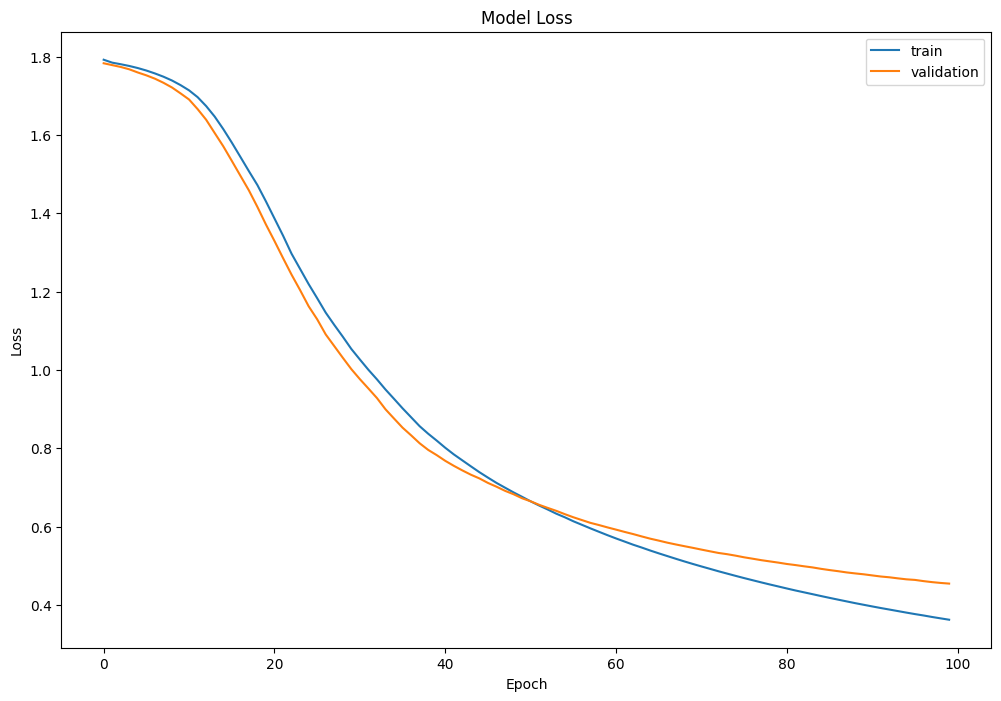

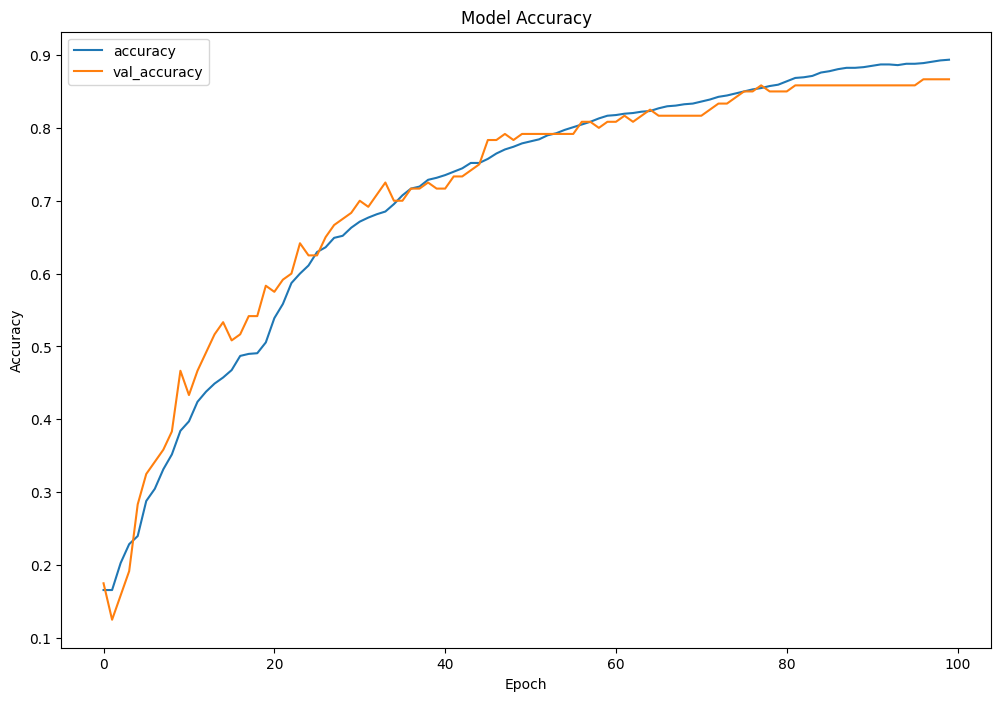

In [73]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on.
df_loss_acc=pd.DataFrame(history.history)
df_loss=df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)
df_acc=df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename({'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)
df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')
